# Solving N-Queens Problem with Genetic, Bee, and Ant Algorithms

Genetic Algorithm Source: "Hands-On Genetic Algorithms with Python" by Eyal Wirsansky. Packt Publishing. 2020.

In [1]:
from deap import base, creator, tools
import random
from array import array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from time import time
from sys import getsizeof

import elitism
import queens

In [2]:
# problem constants:
NUM_OF_QUEENS = 16

# Genetic Algorithm constants:
POPULATION_SIZE = 500
MAX_GENERATIONS = 300
HALL_OF_FAME_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

# set the random seed for repeatable results
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired N-
nQueens = queens.NQueensProblem(NUM_OF_QUEENS)

In [3]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(nQueens)), len(nQueens))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the total distance of the list of cities represented by indices:
def getViolationsCount(individual):
    return nQueens.getViolationsCount(individual),  # return a tuple


toolbox.register("evaluate", getViolationsCount)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(nQueens))
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(nQueens))

In [4]:
def plot_chessboard(best_solution: list[int]) -> None:
    # plot best solution:
    sns.set_style("whitegrid", {'axes.grid' : False})
    nQueens.plotBoard(best_solution)
    plt.show()

# Genetic Algorithm (GA)

In [5]:
# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook, execution_times, population_sizeof, first_gen_min_fitness = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION, ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print hall of fame members info:
print("\n- Best solutions are:")
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

gen	nevals	exec_time_seconds	min	avg   
0  	500   	0.0123389        	3  	10.406
1  	419   	0.011332         	2  	9.016 
2  	449   	0.0104167        	2  	8.396 
3  	406   	0.00810003       	2  	7.944 
4  	430   	0.00818419       	2  	7.434 
5  	430   	0.00839496       	2  	6.96  
6  	438   	0.00758314       	2  	6.87  
7  	441   	0.0070138        	2  	6.818 
8  	427   	0.00670791       	2  	6.79  
9  	419   	0.00647497       	1  	6.696 
10 	440   	0.00645304       	1  	6.776 
11 	422   	0.00661206       	1  	6.656 
12 	433   	0.00644994       	1  	6.588 
13 	434   	0.00652599       	1  	6.418 
14 	426   	0.006387         	1  	6.116 
15 	421   	0.00636911       	1  	5.998 
16 	430   	0.00644994       	1  	6.158 
17 	438   	0.00659418       	1  	6.082 
18 	416   	0.00629878       	1  	6.046 
19 	427   	0.00669909       	1  	5.986 
20 	424   	0.00640583       	1  	5.562 
21 	415   	0.00640011       	1  	5.656 
22 	435   	0.00647593       	1  	5.682 
23 	419   	0.00639415       	1  	5.64  


╒══════════════╤═════════════════════════════╤═══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Generetions │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪═══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          500 │                       80000 │           300 │             0 │         0.366 │         2.10396 │            0.0069899 │
╘══════════════╧═════════════════════════════╧═══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


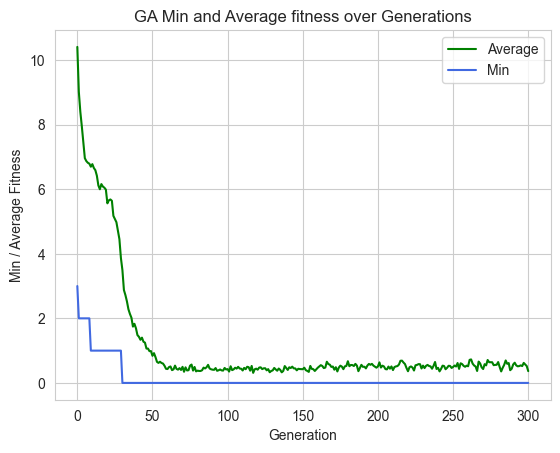

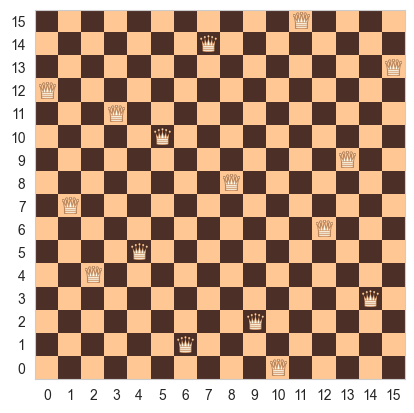

In [6]:
# visualize statistics
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
table = [['Population', 'Population sizeof (Bytes)', 'Generetions', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [POPULATION_SIZE, population_sizeof, MAX_GENERATIONS, minFitnessValues[-1], meanFitnessValues[-1], np.sum(execution_times), np.mean(execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(meanFitnessValues, color='green', label='Average')
plt.plot(minFitnessValues, color='royalblue', label='Min')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('GA Min and Average fitness over Generations')
plt.legend()
plt.show()

plot_chessboard(hof.items[0])

# Artificial Bee Colony (ABC) algorithm

In [ ]:
def neighborhood(ind):
    """Generate a neighbor solution by swapping two random indices in the individual."""
    a, b = random.sample(range(len(ind)), 2)
    neighbor = ind[:]
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

def artificial_bee_colony(fitness_evaluator, pop_size: int, max_cycles: int, limit: int) -> tuple[list, int, list, list, int, list, int]:
    """ Artificial Bee Colony algorithm for N-Queens problem.
    Args:
        fitness_evaluator: A function that evaluates the fitness of an individual.
        pop_size: The number of artificial bees in the population.
        max_cycles: Number of iterations to run the algorithm.
        limit: The number of cycles a bee can go without finding a better solution before becoming a scout.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 
    """
    def f_min(bee):
        return fitness_evaluator(bee)[0]

    # Each bee holds a solution and a trial counter
    bees = [toolbox.individualCreator() for _ in range(pop_size)]
    fitness = [f_min(bee) for bee in bees]
    trials = [0]*pop_size
    bees_sizeof = [getsizeof(bee) for bee in bees]
    
    best = min(zip(bees, fitness), key=lambda x: x[1])
    best_history = []
    mean_history = []
    execution_times = []
    first_iter_min_fitness = None

    print("Iterations:")
    for cycle in range(max_cycles):
        start_time = time()
        # Employed bees phase
        for i in range(pop_size):
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i] = neigh, fit
                trials[i] = 0
                if fit < best[1]:
                    best = (neigh, fit)
                    first_iter_min_fitness = cycle
            else:
                trials[i] += 1

        # Calculate selection probabilities for onlookers
        max_fit = max(fitness)
        probs = [ (max_fit - f + 1e-6) for f in fitness ]
        probs = [p/sum(probs) for p in probs]

        # Onlooker bees phase
        for _ in range(pop_size):
            i = random.choices(range(pop_size), probs)[0]
            neigh = neighborhood(bees[i])
            fit = f_min(neigh)
            if fit < fitness[i]:
                bees[i], fitness[i], trials[i] = neigh, fit, 0
                if fit < best[1]:
                    best = (neigh, fit)
            else:
                trials[i] += 1

        # Scout bees phase
        for i in range(pop_size):
            if trials[i] > limit:
                bees[i] = toolbox.individualCreator()
                bees_sizeof.append(getsizeof(bees[i]))
                fitness[i] = f_min(bees[i])
                trials[i] = 0
        
        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(best[1])
        mean_history.append(np.mean(fitness))
        print(f"{cycle} - Best fitness: {best[1]} - Avg Fitness: {np.mean(fitness):.4f} - Exec Time: {end_time:.4f}s")

    population_sizeof = sum(bees_sizeof)
    return best[0], best[1], best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness

In [11]:
abc_population = POPULATION_SIZE
abc_iterations = MAX_GENERATIONS
trials_limit = 700
abc_sol, abc_val, abc_best_history, abc_mean_history, abc_population_sizeof, abc_execution_times, abc_first_iter_min_fitness = artificial_bee_colony(getViolationsCount, pop_size=abc_population, max_cycles=abc_iterations, limit=trials_limit)
print("\nABC Best Solution", abc_sol)

Iterations:
0 - Best fitness: 2 - Avg Fitness: 8.9360 - Exec Time: 0.0231s
1 - Best fitness: 2 - Avg Fitness: 7.8380 - Exec Time: 0.0199s
2 - Best fitness: 2 - Avg Fitness: 7.0000 - Exec Time: 0.0167s
3 - Best fitness: 2 - Avg Fitness: 6.3820 - Exec Time: 0.0155s
4 - Best fitness: 1 - Avg Fitness: 5.8240 - Exec Time: 0.0173s
5 - Best fitness: 1 - Avg Fitness: 5.4240 - Exec Time: 0.0154s
6 - Best fitness: 1 - Avg Fitness: 5.0620 - Exec Time: 0.0152s
7 - Best fitness: 1 - Avg Fitness: 4.7160 - Exec Time: 0.0153s
8 - Best fitness: 1 - Avg Fitness: 4.4740 - Exec Time: 0.0152s
9 - Best fitness: 1 - Avg Fitness: 4.2740 - Exec Time: 0.0152s
10 - Best fitness: 1 - Avg Fitness: 4.1040 - Exec Time: 0.0155s
11 - Best fitness: 1 - Avg Fitness: 3.9260 - Exec Time: 0.0154s
12 - Best fitness: 1 - Avg Fitness: 3.7800 - Exec Time: 0.0155s
13 - Best fitness: 1 - Avg Fitness: 3.6080 - Exec Time: 0.0152s
14 - Best fitness: 1 - Avg Fitness: 3.4880 - Exec Time: 0.0162s
15 - Best fitness: 1 - Avg Fitness: 3.

╒══════════════╤═════════════════════════════╤══════════════╤════════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Trials Limit │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪════════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          500 │                       80800 │          300 │            700 │             0 │          1.05 │         4.65791 │            0.0155264 │
╘══════════════╧═════════════════════════════╧══════════════╧════════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


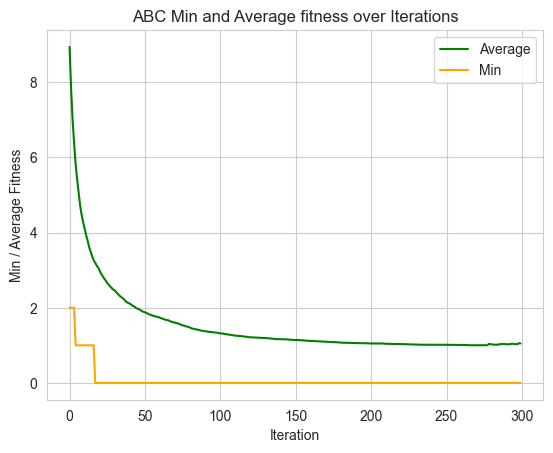

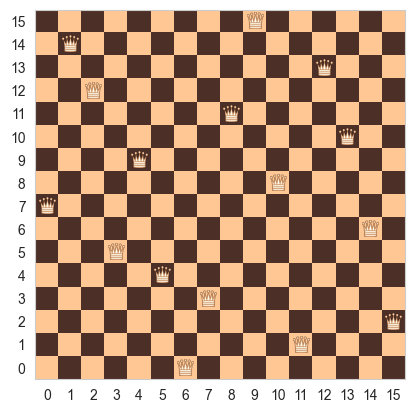

In [12]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Trials Limit', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [abc_population, abc_population_sizeof, abc_iterations, trials_limit, abc_best_history[-1], abc_mean_history[-1], np.sum(abc_execution_times), np.mean(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(abc_mean_history, color='green', label='Average')
plt.plot(abc_best_history, color='orange', label='Min')
plt.xlabel('Iteration')
plt.ylabel('Min / Average Fitness')
plt.title('ABC Min and Average fitness over Iterations')
plt.legend()
plt.show()
plot_chessboard(abc_sol)

# Ant Colony Optimization (ACO) algorithm

In [ ]:
def ant_colony_optimization(n_queens: int, fitness_evaluator, pop_size: int, max_cycles: int, alpha=1.0, beta=3.0, rho=0.3, Q=1.0) -> tuple[list, int, list, list, int, list]:
    """ Ant Colony Optimization for N-Queens problem.
    Args:
        n_queens (int): Number of queens (and board size).
        fitness_evaluator: Function to evaluate the fitness of a solution.
        pop_size (int): Number of artificial ants to generate.
        max_cycles (int): Number of iterations to run the algorithm.
        alpha (float): Influence of the pheromone level (tau) in selecting the next chessboard square (≥ 0).
        beta (float): Influence of the influence of the cost (eta) for selecting the next chessboard square (≥ 0).
        rho (float): Pheromone evaporation rate (between 0 and 1).
        Q (float): Pheromone deposit constant.
    Returns:
        tuple: best solution, best fitness, history of best fitness, history of mean fitness, total population size in bytes, execution times, first iteration min fitness. 
    """
    # Initial pheromone level τ matrix
    tau = np.ones((n_queens, n_queens))
    # heuristic η matrix, cost of placing a queen in a row of a column
    eta = np.ones((n_queens, n_queens))

    best_solution = None
    best_value = float('inf')  # (+) for minimization; (-) for maximizing
    best_history = []
    mean_history = []
    ants_sizeof = []

    print("Iterations:")
    for cycle in range(max_cycles):
        start_time = time()
        all_solutions = []
        all_fitness = []

        for ant in range(pop_size):
            ants_sizeof.append(getsizeof(ant))
            solution = []
            available_rows = set(range(n_queens))

            # Calculating the chessboard squares attractiveness and probabilities over available rows
            for col in range(n_queens):
                weights = []
                for row in available_rows:
                    weights.append((tau[col, row]**alpha) * (eta[col, row]**beta))
                probs = [w/sum(weights) for w in weights]
                chosen = random.choices(list(available_rows), probs)[0]
                solution.append(chosen)
                available_rows.remove(chosen)
            fit = fitness_evaluator(solution)[0]
            all_solutions.append(solution)
            all_fitness.append(fit)

            # Update best solution
            if fit < best_value:
                best_value = fit
                best_solution = solution.copy()
                first_iter_min_fitness = cycle

        # Evaporate
        tau *= (1 - rho)

        # Deposit pheromone: only best ant (or all)
        for sol, fit in zip(all_solutions, all_fitness):
            deposit = Q / (1 + fit)
            for col, row in enumerate(sol):
                tau[col, row] += deposit

        end_time = time()-start_time
        execution_times.append(end_time)
        best_history.append(best_value)
        mean_history.append(np.mean(all_fitness))
        print(f"{cycle} - Best fitness: {best_value} - Avg Fitness: {np.mean(all_fitness):.4f} - Exec Time: {end_time:.4f}s")

    population_sizeof = sum(ants_sizeof)
    return best_solution, best_value, best_history, mean_history, population_sizeof, execution_times, first_iter_min_fitness

In [14]:
aco_population = POPULATION_SIZE
aco_iterations = MAX_GENERATIONS
aco_sol, aco_val, aco_best_history, aco_mean_history, aco_population_sizeof, aco_execution_times, aco_first_iter_min_fitness = ant_colony_optimization(NUM_OF_QUEENS, getViolationsCount, pop_size=aco_population, max_cycles=aco_iterations)
print("\nACO best solution:", aco_sol)

Iterations:
0 - Best fitness: 2 - Avg Fitness: 10.2980 - Exec Time: 0.0764s
1 - Best fitness: 2 - Avg Fitness: 10.1860 - Exec Time: 0.0513s
2 - Best fitness: 2 - Avg Fitness: 10.2520 - Exec Time: 0.0507s
3 - Best fitness: 2 - Avg Fitness: 10.3800 - Exec Time: 0.0505s
4 - Best fitness: 2 - Avg Fitness: 10.2800 - Exec Time: 0.0511s
5 - Best fitness: 2 - Avg Fitness: 10.5040 - Exec Time: 0.0520s
6 - Best fitness: 2 - Avg Fitness: 10.3160 - Exec Time: 0.0526s
7 - Best fitness: 2 - Avg Fitness: 10.6780 - Exec Time: 0.0510s
8 - Best fitness: 2 - Avg Fitness: 10.3340 - Exec Time: 0.0506s
9 - Best fitness: 2 - Avg Fitness: 10.0360 - Exec Time: 0.0504s
10 - Best fitness: 2 - Avg Fitness: 10.4920 - Exec Time: 0.0535s
11 - Best fitness: 2 - Avg Fitness: 10.4400 - Exec Time: 0.0516s
12 - Best fitness: 2 - Avg Fitness: 10.2220 - Exec Time: 0.0511s
13 - Best fitness: 2 - Avg Fitness: 10.2600 - Exec Time: 0.0505s
14 - Best fitness: 2 - Avg Fitness: 10.1380 - Exec Time: 0.0513s
15 - Best fitness: 2 - 

╒══════════════╤═════════════════════════════╤══════════════╤═══════════════╤═══════════════╤═════════════════╤══════════════════════╕
│   Population │   Population sizeof (Bytes) │   Iterations │   Min Fitness │   Avg Fitness │   Exec Time (s) │   Avg Exec Times (s) │
╞══════════════╪═════════════════════════════╪══════════════╪═══════════════╪═══════════════╪═════════════════╪══════════════════════╡
│          500 │                     4200000 │          300 │             0 │         7.398 │          17.485 │            0.0290932 │
╘══════════════╧═════════════════════════════╧══════════════╧═══════════════╧═══════════════╧═════════════════╧══════════════════════╛


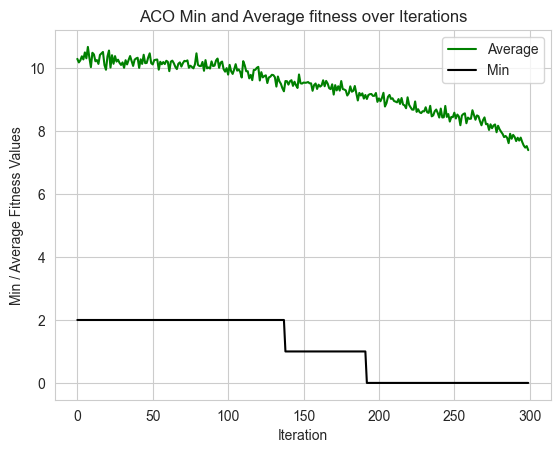

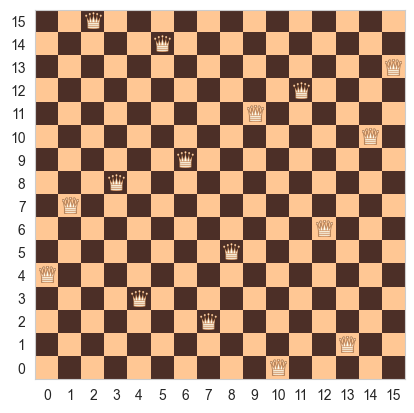

In [15]:
table = [['Population', 'Population sizeof (Bytes)', 'Iterations', 'Min Fitness', 'Avg Fitness', 'Exec Time (s)', 'Avg Exec Times (s)'], 
         [aco_population, aco_population_sizeof, aco_iterations, aco_best_history[-1], aco_mean_history[-1], np.sum(aco_execution_times), np.mean(aco_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
sns.set_style("whitegrid")
plt.plot(aco_mean_history, color='green', label='Average')
plt.plot(aco_best_history, color='black', label='Min')
plt.xlabel('Iteration')
plt.ylabel('Min / Average Fitness Values')
plt.title('ACO Min and Average fitness over Iterations')
plt.legend()
plt.show()
plot_chessboard(aco_sol)

# GA vs ACO vs ABC

Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony
╒═════════════╤═══════╤════════╤═══════════════╤═══════════════╤═══════════════════════════════════════╤═════════════════╕
│ Algorithm   │   Pop │   Iter │   Min Fitness │   Avg Fitness │   N° which achieved first min fitness │   Exec Time (s) │
╞═════════════╪═══════╪════════╪═══════════════╪═══════════════╪═══════════════════════════════════════╪═════════════════╡
│ GA          │   500 │    300 │             0 │         0.366 │                                    30 │        17.485   │
├─────────────┼───────┼────────┼───────────────┼───────────────┼───────────────────────────────────────┼─────────────────┤
│ ACO         │   500 │    300 │             0 │         7.398 │                                   192 │        17.485   │
├─────────────┼───────┼────────┼───────────────┼───────────────┼───────────────────────────────────────┼─────────────────┤
│ ABC         │   500 │    300 │             0 │         1.

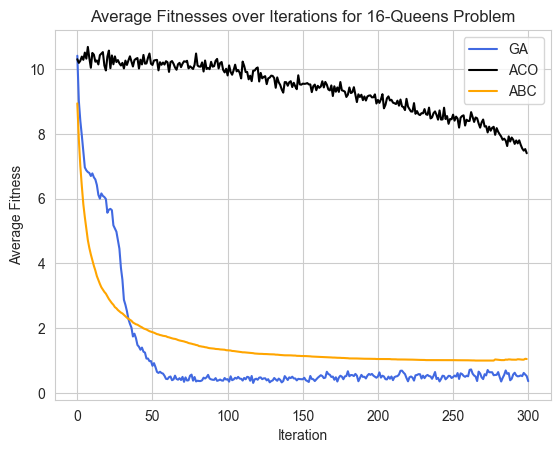

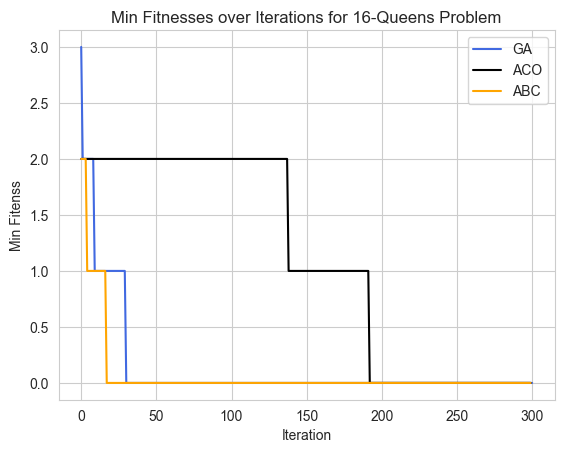

In [ ]:
print("Comparing Genetic Algorithm, Ant Colony Optimization, and Artificial Bee Colony")

table = [['Algorithm', 'Pop', 'Iter', 'Min Fitness', 'Avg Fitness', 'N° iter which achieved first min fitness', 'Exec Time (s)'], 
         ['GA', POPULATION_SIZE, MAX_GENERATIONS, minFitnessValues[-1], meanFitnessValues[-1], first_gen_min_fitness, np.sum(execution_times)],
         ['ACO', aco_population, aco_iterations, aco_best_history[-1], aco_mean_history[-1], aco_first_iter_min_fitness, np.sum(aco_execution_times)],
         ['ABC', abc_population, abc_iterations, abc_best_history[-1], abc_mean_history[-1], abc_first_iter_min_fitness, np.sum(abc_execution_times)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

sns.set_style("whitegrid")
plt.plot(meanFitnessValues, color='royalblue', label='GA')
plt.plot(aco_mean_history, color='black', label='ACO')
plt.plot(abc_mean_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Average Fitness')
plt.title(f'Average Fitnesses over Iterations for {NUM_OF_QUEENS}-Queens Problem')
plt.legend()
plt.show()

sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='royalblue', label='GA')
plt.plot(aco_best_history, color='black', label='ACO')
plt.plot(abc_best_history, color='orange', label='ABC')
plt.xlabel('Iteration')
plt.ylabel('Min Fitenss')
plt.title(f'Min Fitnesses over Iterations for {NUM_OF_QUEENS}-Queens Problem')
plt.legend()
plt.show()